# Building Amenity Metapaths on Streets from OpenStreetMap

This notebook introduces the way of adding metapaths on heterogeous graph using functions from `city2graph`.

## What is a Metapath?
A **metapath** is a composite relation that defines a path through a heterogeneous graph, connecting nodes across multiple edge types.

For example, consider a heterogeneous graph with three node types:
- **Amenity** nodes (e.g., cafes, restaurants)
- **Segment** nodes (representing street segments in a dual graph)

And edge types:
- `("amenity", "is_nearby", "segment")`: connects an amenity to its nearest street segment
- `("segment", "connects", "segment")`: connects adjacent street segments

A metapath like `Amenity → Segment → Segment → Amenity` represents a walk where:
1. Start at an Amenity
2. Move to a connected Segment (via "is_nearby")
3. Move to another connected Segment (via "connects")
4. Arrive at another Amenity (via "is_nearby", reversed)

This captures the idea of "amenities accessible via walking two street segments apart."

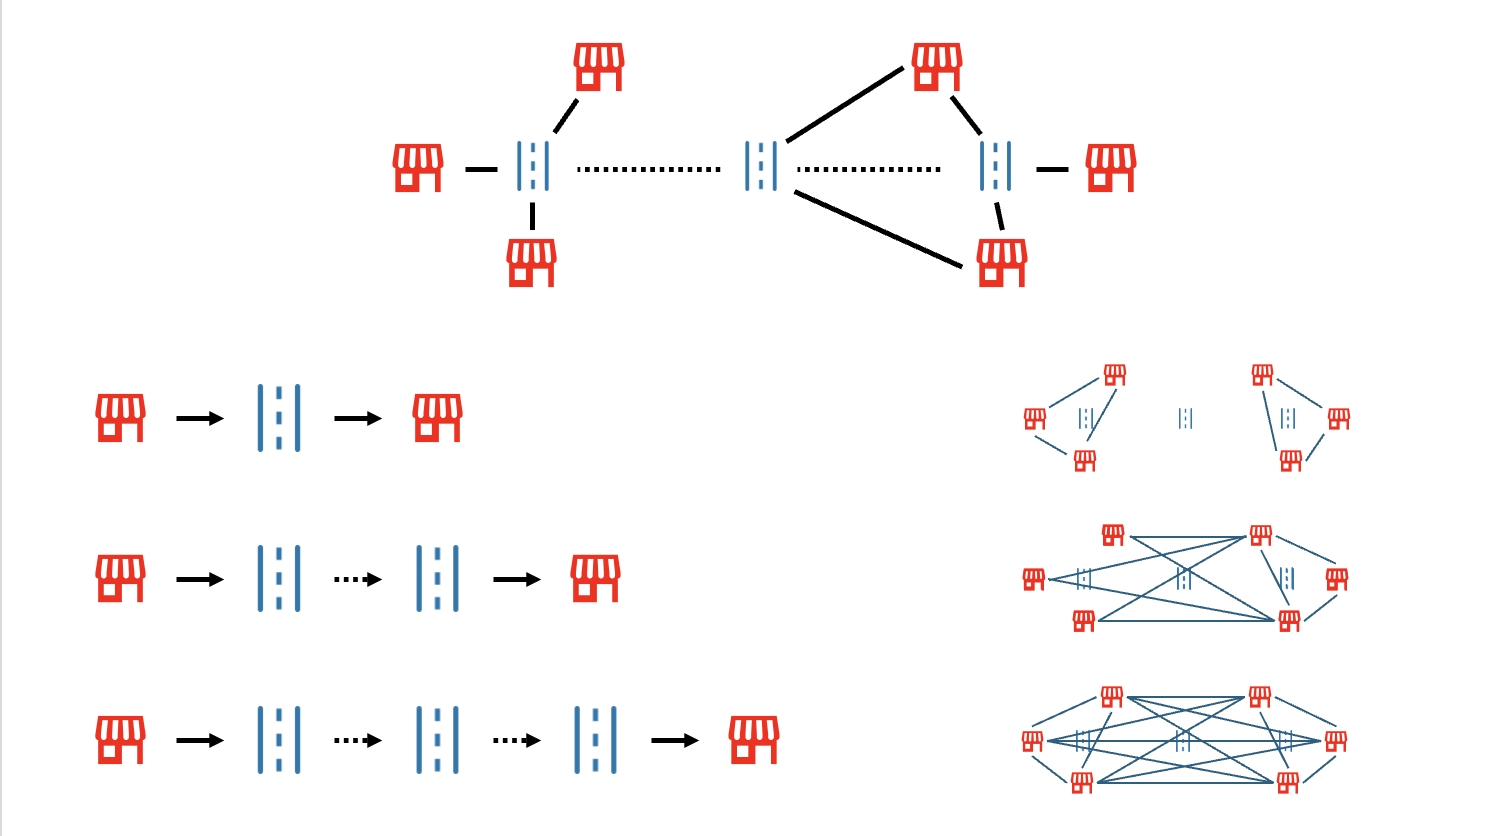

This walkthrough pulls the real street network around Soho (central London) from OpenStreetMap with ``osmnx``. We convert the primary street graph to its dual representation where street primary edges become street dual nodes and connections between adjacent street primary edges become street dual edges. We build a heterogeneous graph where amenities are attached to their closest street dual nodes. Finally, ``add_metapaths`` materialises Amenity → street dual node → street dual node → Amenity walks so we can analyse higher-order access between attractions.

In [1]:
import geopandas as gpd
import osmnx as ox
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import city2graph as c2g

`city2graph` provides direct support for objects obtained from `osmnx`. We first construct the dual graph from the primary street network of Soho.

In [2]:
# Download and project the street network to British National Grid (EPSG:27700) for metric distances
# Data should be obtained from Only in Soho, London
G_drive = ox.graph_from_place(
    "Soho, London",
    network_type="all",
)
G_proj = ox.project_graph(G_drive, to_crs="EPSG:27700")

# Convert to dual graph
street_primary_nodes, street_primary_edges = c2g.nx_to_gdf(G_proj)
projected_crs = street_primary_edges.crs

We also fetch the amenity POIs in the same extent.

In [3]:
amenity_tags = ["cafe", "restaurant", "pub", "bar", "museum", "theatre", "cinema"]
amenity_candidates = ox.features_from_place(
    "Soho, London",
    tags={"amenity": amenity_tags},
).to_crs(projected_crs)

print(f"Street primary edges: {len(street_primary_edges):,}")
print(f"Street primary nodes: {len(street_primary_nodes):,}")
print(f"Candidate Amenities: {len(amenity_candidates):,}")

Street primary edges: 2,163
Street primary nodes: 784
Candidate Amenities: 432


With the obtained street primary edges and street primary nodes, we construct a dual graph using `dual_graph`. In this dual representation, street primary edges become street dual nodes, and adjacencies between street primary edges become street dual edges, effectively flipping the primary graph to facilitate higher-order network analysis. This transformation allows us to model connectivity at the segment level, where each street dual node represents a street segment and street dual edges represent possible transitions between them.

In [4]:
# Convert to dual graph
street_dual_nodes, street_dual_edges = c2g.dual_graph((street_primary_nodes, street_primary_edges))

# Drop the multi-index
street_dual_nodes = street_dual_nodes.droplevel(2)

Next we clean the raw GeoDataFrames so they are ready for ``bridge_nodes`` and ``add_metapaths``.

In [5]:
# Name street dual nodes
street_dual_nodes.index.name = "segment_id"

# Add distance to dual edges
street_dual_edges["distance_m"] = street_dual_edges.geometry.length

# Collapse complex Amenity geometries to points within the projected CRS
amenities = (
    amenity_candidates[["name", "amenity", "geometry"]]
    .copy()
    .explode(index_parts=False)
    .dropna(subset=["geometry"])
)
non_point_mask = ~amenities.geometry.geom_type.isin(["Point"])
amenities.loc[non_point_mask, "geometry"] = amenities.loc[non_point_mask, "geometry"].centroid
amenities = amenities.set_geometry("geometry")
amenities["name"] = amenities["name"].fillna(amenities["amenity"].str.title())
amenities = amenities[~amenities.geometry.is_empty]
amenities = amenities.drop_duplicates(subset="geometry").reset_index(drop=True)

In [6]:
# Prepare directed street dual edges (u, v) with metric distances
street_dual_edges.index.names = ["source_segment", "target_segment"]
street_dual_edges = gpd.GeoDataFrame(street_dual_edges, geometry="geometry", crs=projected_crs)

print(f"Filtered Amenities: {len(amenities):,}")
print(f"Prepared street dual edges: {len(street_dual_edges):,}")

Filtered Amenities: 432
Prepared street dual edges: 4,157


Bridge every amenity to its nearest street dual node so the heterogeneous graph links amenities back into the street network. For the example of ``bridge_nodes``, please see [this notebook](https://city2graph.net/examples/generating_graphs_by_proximity.html).

In [7]:
_, bridge_edges = c2g.bridge_nodes(
    {"amenity": amenities, "segment": street_dual_nodes},
    proximity_method="knn",
    k=1,
)
amenity_to_segment = bridge_edges[("amenity", "is_nearby", "segment")].copy()
amenity_to_segment = amenity_to_segment.rename(columns={"weight": "distance_m"})
amenity_to_segment.index.names = ["amenity_id", "segment_id"]

nodes = {"segment": street_dual_nodes, "amenity": amenities}
edges = {
    ("segment", "connects", "segment"): street_dual_edges,
    ("amenity", "is_nearby", "segment"): amenity_to_segment,
}

avg_links = len(amenity_to_segment) / max(len(amenities), 1)
print(
    f"Amenity→segment links: {len(amenity_to_segment):,} (≈{avg_links:.1f} per Amenity)"
)

Amenity→segment links: 432 (≈1.0 per Amenity)


With the heterogeneous graph assembled, we can ask for Amenity → street dual node → street dual node → Amenity metapaths and aggregate their total walking distance. In this example, we have totally 5 hopes of streets between amenities (4 street → street relations in between). By specifying `edge_attr` and `edge_attr_agg`, we can also calculate the statistics on edge attributes that are common across edge types (e.g. distance, travel time, etc.).

In [8]:
metapaths = [[("amenity", "is_nearby", "segment"),
              ("segment", "connects", "segment"),
              ("segment", "connects", "segment"),
              ("segment", "connects", "segment"),
              ("segment", "connects", "segment"),
              ("segment", "is_nearby", "amenity")]]

nodes_with_mp, edges_with_mp = c2g.add_metapaths(
    (nodes, edges),
    metapaths,
    edge_attr="distance_m",
    edge_attr_agg="sum",
)

As seen below, one edge type has been added:

In [9]:
for edge_type in edges_with_mp.keys():
    print(f"{edge_type}: {len(edges_with_mp[edge_type]):,} edges")

('segment', 'connects', 'segment'): 4,157 edges
('amenity', 'is_nearby', 'segment'): 432 edges
('amenity', 'metapath_0', 'amenity'): 776 edges


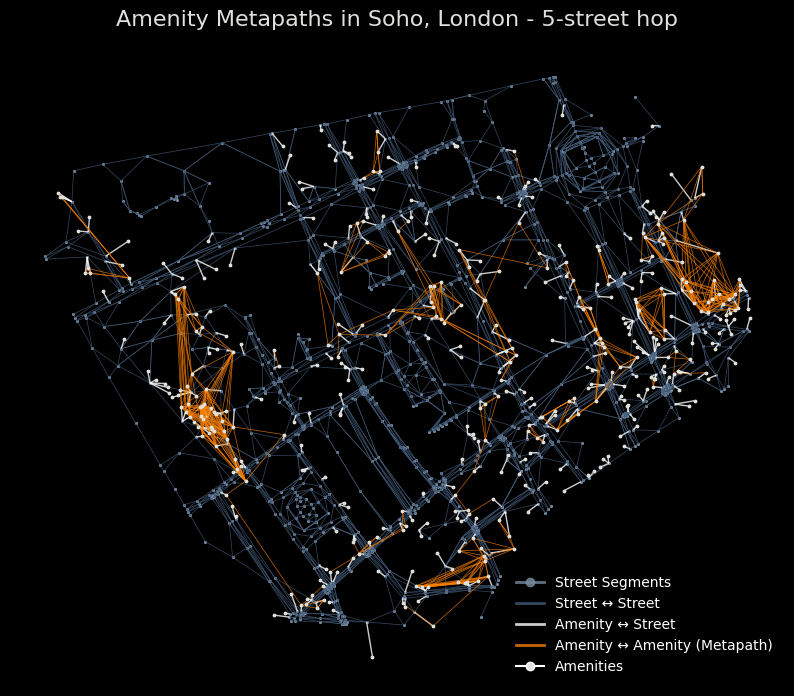

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

# Set dark background
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# extract metapath edges
metapath_edges = edges_with_mp[("amenity", "metapath_0", "amenity")]

# Plot all edges: street dual edges, street dual nodes (segments), Amenity to segment links, and metapaths
street_dual_nodes.centroid.plot(ax=ax, color="#778ca3", markersize=1, alpha=0.8, zorder=1)  # Muted blue-gray for street dual nodes (segments)
street_dual_edges.plot(ax=ax, color="#415a77", linewidth=0.5, alpha=0.8, zorder=1)  # Muted blue-gray for street dual edges
amenity_to_segment.plot(ax=ax, color="white", linewidth=1.0, alpha=0.8, zorder=2)  # White for Amenity links (increased linewidth and alpha for visibility)
if not metapath_edges.empty:
    metapath_edges.plot(ax=ax, color="#f77f00", linewidth=0.5, alpha=0.8, zorder=3)  # Warm orange for metapaths (reduced linewidth)

# Treat all amenities as the same nodes: use a single color for all Amenities
amenity_color = "#e0e1dd"  # Light beige for Amenities
ax.scatter(
    amenities.geometry.x,
    amenities.geometry.y,
    s=3,
    color=amenity_color,
    zorder=4,
)

ax.set_title("Amenity Metapaths in Soho, London - 5-street hop", fontsize=16, pad=16, color="#e0e1dd")  # Light title
ax.set_axis_off()

legend_elements = [
    Line2D([0], [0], marker="o", color="#778ca3", lw=2, alpha=0.8, label="Street Segments"),
    Line2D([0], [0], color="#415a77", lw=2, alpha=0.8, label="Street ↔ Street"),
    Line2D([0], [0], color="white", lw=2, alpha=0.8, label="Amenity ↔ Street"),
    Line2D([0], [0], color="#f77f00", lw=2, alpha=0.8, label="Amenity ↔ Amenity (Metapath)"),
    Line2D([0], [0], marker="o", color="w", label="Amenities", markerfacecolor=amenity_color, markersize=6),
]
ax.legend(handles=legend_elements, loc="lower right", frameon=False, fontsize=10, labelcolor='white')

plt.show()

By stacking metapaths while adding the relations, we can see the growth of metapaths:

In [11]:
metapaths = []
metapath_edges = []

for i in range(0, 10):
    metapaths = [[("amenity", "is_nearby", "segment")] + [("segment", "connects", "segment")] * i + [("segment", "is_nearby", "amenity")]]

    nodes_with_mp, edges_with_mp = c2g.add_metapaths(
        (nodes, edges),
        metapaths,
        edge_attr="distance_m",
        edge_attr_agg="sum",
    )
    metapath_edges.append(edges_with_mp[(f"amenity", "metapath_0", "amenity")])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Set dark background
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plot static parts
street_dual_nodes.centroid.plot(ax=ax, color="#778ca3", markersize=1, alpha=0.8, zorder=1)
street_dual_edges.plot(ax=ax, color="#415a77", linewidth=0.5, alpha=0.8, zorder=1)
amenity_to_segment.plot(ax=ax, color="white", linewidth=1.0, alpha=0.8, zorder=2)
ax.scatter(
    amenities.geometry.x,
    amenities.geometry.y,
    s=3,
    color=amenity_color,
    zorder=4,
)

ax.set_title("Amenity Metapaths in Soho, London - 1-street hop", fontsize=16, pad=16, color="#e0e1dd")
ax.set_axis_off()

legend_elements = [
    Line2D([0], [0], marker="o", color="#778ca3", lw=2, alpha=0.8, label="Street Segments"),
    Line2D([0], [0], color="#415a77", lw=2, alpha=0.8, label="Street ↔ Street"),
    Line2D([0], [0], color="white", lw=2, alpha=0.8, label="Amenity ↔ Street"),
    Line2D([0], [0], color="#f77f00", lw=2, alpha=0.8, label="Amenity ↔ Amenity (Metapath)"),
    Line2D([0], [0], marker="o", color="w", label="Amenities", markerfacecolor=amenity_color, markersize=6),
]
ax.legend(handles=legend_elements, loc="lower right", frameon=False, fontsize=10, labelcolor='white')

# Animate the metapaths one by one
def animate(frame):
    hop = frame + 1
    ax.set_title(f"Amenity Metapaths in Soho, London - {hop}-street hop", fontsize=16, pad=16, color="#e0e1dd")
    if not metapath_edges[frame].empty:
        metapath_edges[frame].plot(ax=ax, color="#f77f00", linewidth=0.5, alpha=0.8, zorder=3)

anim = FuncAnimation(fig, animate, frames=len(metapath_edges), interval=1000, repeat=True)
anim.save('../_static/metapath.gif', writer='pillow')

![Metapath Animation](https://city2graph.net/_static/metapath.gif)